## Modelos de Clasificación - Predicción de Propinas en un Restaurante

En esta actividad, utilizaremos el conjunto de datos *"tips"* de la librería Seaborn, sobre el cual ya se realizó un análisis exploratorio de datos (EDA) en el informe anterior. El objetivo de esta tarea es implementar varios modelos de clasificación para predecir la propina que cada cliente deja, en función de sus principales características.

A lo largo de este informe, se desarrollarán y evaluarán modelos de regresión logística y máquinas de vector Soporte (SVM). Para cada modelo, se calcularán y analizarán las métricas clave, como la precisión, el recall, y la F1, con el fin de comprender mejor el rendimiento y la capacidad predictiva de cada enfoque.

## Librerías Utilizadas

Para llevar a cabo esta actividad, utilizaremos las siguientes librerías:

In [84]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Aplicación de modelos
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns


# Configuración de las Gráficas
# ==============================================================================
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6, 4.5]
palette = ["#003049","#d62828","#f77f00","purple","#fcbf49"]
sns.set_theme( palette= palette, context= "notebook")


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 1. Ingesta de Datos

A continuación, procederemos a importar el conjunto de datos que utilizaremos. Este dataset forma parte de la librería Seaborn.

In [85]:
# Cargamos el conjunto de datos "tips"
# ==============================================================================

tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


## 2. Resumen de Datos

A continuación, realizaremos un resumen general de los datos para tener una visión clara de su estructura. Si deseas ver un análisis exploratorio de datos (EDA) más detallado, te invitamos a revisar el siguiente informe, donde se exploró el conjunto de datos en profundidad, identificando patrones, tendencias y relaciones clave:

[Clientes Restaurante - Análisis Exploratorio de Datos (EDA)](https://analisishectorrodriguez.blogspot.com/2024/09/clientes-restaurante-analisis.html)


In [86]:
# Obtenemos información general del conjunto de datos
# ==============================================================================

tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


A continuación, calcularemos los estadísticos descriptivos para obtener una visión general de las características clave de nuestros datos. Dado que contamos con tanto variables cuantitativas como cualitativas, comenzaremos con los estadísticos descriptivos de las variables cualitativas.

In [87]:
# Hallamos los estadísticos descriptivos básicos de las variables cualitativas
# ==============================================================================

tips.describe(include= 'category')

,sex,smoker,day,time
count,244,244,244,244
unique,2,2,4,2
top,Male,No,Sat,Dinner
freq,157,151,87,176


Ahora procederemos a calcular los estadísticos descriptivos de las variables cuantitativas.

In [88]:
# Hallamos los estadísticos descriptivos básicos de las variables cuantitativas
# ==============================================================================

tips.describe(include= [np.number])

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


# 3. Preprocesado de Datos

A continuación, prepararemos los datos para la implementación de los modelos de clasificación.

## 3.1 Observaciones Duplicadas

Recordemos que, en el análisis exploratorio de datos, detectamos una fila duplicada. Procederemos a eliminarla, ya que, aunque sea solo una observación, es una buena práctica evitar duplicados que puedan sesgar nuestros modelos.

In [89]:
# Eliminamos las observaciones con valores duplicados
# ==============================================================================

tips = tips.drop_duplicates().reset_index(drop=True)

Verificamos que la observación duplicada haya sido eliminada correctamente.

In [90]:
# Comprobamos que se han eliminado la observación duplicada
# ==============================================================================

tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  243 non-null    float64 
 1   tip         243 non-null    float64 
 2   sex         243 non-null    category
 3   smoker      243 non-null    category
 4   day         243 non-null    category
 5   time        243 non-null    category
 6   size        243 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.3 KB


## 3.2 Categorización de la Variable Objetivo

En esta sección, transformaremos la variable numérica objetivo en categorías, ya que los modelos que implementaremos son de clasificación. Para ello, utilizaremos la instrucción `KBinsDiscretizer` de la librería `sklearn`, que nos permitirá dividir la variable cuantitativa en cuatro categorías. Esta transformación se realizará de manera que cada categoría tenga una cantidad similar de observaciones, facilitando así la clasificación en los modelos.

In [91]:
# Usamos KBinsDiscretizer para dividir las propinas en cuatro categorías
# ==============================================================================

kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Creamos una nueva columna 'tip_category' que indica el rango de la propina
# ==============================================================================

tips['tip_category'] = kbins.fit_transform(tips[['tip']]).astype(int)

Observamos el conjunto de datos

In [92]:
# Imprimimos las primeras filas del conjunto de datos
# ==============================================================================

tips.head(20)

,total_bill,tip,sex,smoker,day,time,size,tip_category
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,0
2,21.01,3.50,Male,No,Sun,Dinner,3,2
3,23.68,3.31,Male,No,Sun,Dinner,2,2
4,24.59,3.61,Female,No,Sun,Dinner,4,3
5,25.29,4.71,Male,No,Sun,Dinner,4,3
6,8.77,2.00,Male,No,Sun,Dinner,2,1
7,26.88,3.12,Male,No,Sun,Dinner,4,2
8,15.04,1.96,Male,No,Sun,Dinner,2,0
9,14.78,3.23,Male,No,Sun,Dinner,2,2


Podemos observar que se ha creado una nueva columna llamada **"tip_category"**, la cual indica el grupo al que pertenece la propina que ha dejado el cliente en el restaurante. Las categorías de la propina se han mapeado de la siguiente manera:

In [93]:
# Obtenemos los puntos de corte de las categorías de propinas creadas por KBinsDiscretizer
# ==============================================================================

bin_edges = kbins.bin_edges_
print("Puntos de corte:", bin_edges)

Puntos de corte: [array([ 1.   ,  2.   ,  2.92 ,  3.575, 10.   ])]


- **≤ 2:** 0 - Indica que la propina ha sido baja
- **2 < x ≤ 2.92:** 1 - Indica que la propina ha sido moderada
- **2.92 < x ≤ 3.575:** 2 - Indica que la propina ha sido alta
- **3.575 < x ≤ 10:** 3 - Indica que la propina ha sido muy alta

Ahora procederemos a comprobar la cantidad de observaciones en cada categoría generada. Esto nos permitirá verificar el balance de las clases y asegurarnos de que el modelo no esté sesgado hacia alguna categoría en particular.

In [94]:
# Comprobamos la cantidad de observaciones en cada categoría de propinas creadas por KBinsDiscretizer 
# ==============================================================================

tips['tip_category'].value_counts()

tip_category
1    76
2    61
3    61
0    45
Name: count, dtype: int64

Dado que la variable categórica está representada por valores numéricos, vamos a modificarla para que sea más descriptiva y fácil de interpretar. Esto facilitará la comprensión y el análisis de los modelos.

In [95]:
# Modificamos la columna 'tip_category' para que sea más descriptiva
# ==============================================================================

tips['tip_category'] = np.where(tips['tip_category'] == 0, 'bajo',
                                np.where(tips['tip_category'] == 1, 'moderado',
                                         np.where(tips['tip_category'] == 2, 'alto', 'muy alto'))
                                )

tips['tip_category'] = tips['tip_category'].astype('category')


In [96]:
# Comprobamos que los cambios se han realizado correctamente
# ==============================================================================

tips.head(20)

,total_bill,tip,sex,smoker,day,time,size,tip_category
0,16.99,1.01,Female,No,Sun,Dinner,2,bajo
1,10.34,1.66,Male,No,Sun,Dinner,3,bajo
2,21.01,3.50,Male,No,Sun,Dinner,3,alto
3,23.68,3.31,Male,No,Sun,Dinner,2,alto
4,24.59,3.61,Female,No,Sun,Dinner,4,muy alto
5,25.29,4.71,Male,No,Sun,Dinner,4,muy alto
6,8.77,2.00,Male,No,Sun,Dinner,2,moderado
7,26.88,3.12,Male,No,Sun,Dinner,4,alto
8,15.04,1.96,Male,No,Sun,Dinner,2,bajo
9,14.78,3.23,Male,No,Sun,Dinner,2,alto


In [97]:
 # Comprobamos que la columna 'tip_category' se ha modificado correctamente
# ==============================================================================

tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   total_bill    243 non-null    float64 
 1   tip           243 non-null    float64 
 2   sex           243 non-null    category
 3   smoker        243 non-null    category
 4   day           243 non-null    category
 5   time          243 non-null    category
 6   size          243 non-null    int64   
 7   tip_category  243 non-null    category
dtypes: category(5), float64(2), int64(1)
memory usage: 7.8 KB


Una vez establecidas las categorías correspondientes para cada propina, podemos eliminar la variable **"tip"**. La razón para eliminar esta variable es que ya hemos creado una nueva columna, **"tip_category"**, que contiene la misma información de manera categórica y más útil para los modelos de clasificación. Mantener la variable numérica original podría ser redundante y no aportar valor adicional a nuestro análisis, por lo que eliminarla simplifica y clarifica el conjunto de datos.

In [98]:
# Eliminamos la columna 'tip' ya que estamos prediciendo 'tip_category'
# ==============================================================================

tips.drop('tip', axis=1, inplace=True)

## 3.3 Mapeo Numérico de las Variables Cualitativas

A continuación, realizaremos un mapeo numérico de las variables cualitativas. Generalmente, los modelos de aprendizaje automático no pueden procesar directamente datos categóricos, ya que requieren trabajar con valores numéricos. Por ello, es necesario convertir estas variables en una representación numérica antes de entrenar los modelos. Para este propósito, emplearemos técnicas como la codificación *One-Hot*, asegurando que los modelos puedan interpretar correctamente la información categórica sin introducir sesgos en el proceso de clasificación. Por lo tanto, procederemos a mapear las variables categóricas a variables numéricas mediante la técnica de One-Hot-Encoding. La única variable categórica a la que no se le aplicará el mapeo numérico es la variable dependiente, que es la que queremos predecir.

In [99]:
# Capturamos las variables categóricas de nuestro conjunto de datos a excepción de la variable objetivo
# ==============================================================================

caracteristicas_categoricas = tips.select_dtypes(include=['category']).columns.drop('tip_category')
caracteristicas_categoricas

# Realizamos la codificación de las variables categóricas a través de la técnica de One-Hot Encoding
# ==============================================================================

onehot = OneHotEncoder(handle_unknown='ignore', 
                       drop= 'if_binary', 
                       sparse_output= False
                       )

codificacion = onehot.fit_transform(tips[caracteristicas_categoricas])

# Trasformamos los datos codificados en un DataFrame
# ==============================================================================

columnas = onehot.get_feature_names_out(input_features=caracteristicas_categoricas)
codificacion = pd.DataFrame(codificacion, columns=columnas)
codificacion


,sex_Male,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Lunch
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
238,1.0,0.0,0.0,1.0,0.0,0.0,0.0
239,0.0,1.0,0.0,1.0,0.0,0.0,0.0
240,1.0,1.0,0.0,1.0,0.0,0.0,0.0
241,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Ahora procederemos a unir el conjunto de datos que contiene el mapeo numérico de las variables categóricas. Además, eliminaremos las variables originales que aún mantienen su naturaleza cualitativa, ya que han sido reemplazadas por su correspondiente representación numérica. Esto nos permitirá evitar redundancias y garantizar que los modelos trabajen únicamente con variables que pueden procesar de manera eficiente.

In [100]:
# Concatenamos el DataFrame original con el DataFrame de las variables codificadas
# ==============================================================================

df = pd.concat([tips, codificacion], axis=1)

# Eliminamos las variables categóricas originales
# ==============================================================================

df = df.drop(columns=caracteristicas_categoricas)
df

,total_bill,size,tip_category,sex_Male,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Lunch
0,16.99,2,bajo,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10.34,3,bajo,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,21.01,3,alto,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23.68,2,alto,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24.59,4,muy alto,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
238,29.03,3,muy alto,1.0,0.0,0.0,1.0,0.0,0.0,0.0
239,27.18,2,moderado,0.0,1.0,0.0,1.0,0.0,0.0,0.0
240,22.67,2,moderado,1.0,1.0,0.0,1.0,0.0,0.0,0.0
241,17.82,2,bajo,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [101]:
# Observamos la cantidad de observaciones y variables que tiene el conjunto de datos
# ==============================================================================

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   total_bill    243 non-null    float64 
 1   size          243 non-null    int64   
 2   tip_category  243 non-null    category
 3   sex_Male      243 non-null    float64 
 4   smoker_Yes    243 non-null    float64 
 5   day_Fri       243 non-null    float64 
 6   day_Sat       243 non-null    float64 
 7   day_Sun       243 non-null    float64 
 8   day_Thur      243 non-null    float64 
 9   time_Lunch    243 non-null    float64 
dtypes: category(1), float64(8), int64(1)
memory usage: 17.7 KB


Podemos observar que, después de aplicar el mapeo numérico sobre las variables categóricas, el conjunto de datos resultante cuenta con un total de 11 columnas. Este conjunto de datos ahora contiene únicamente variables numéricas, lo que facilita su procesamiento por parte de los modelos de clasificación.

## 3.4 División del Conjunto de Datos de Entrenamiento y Prueba

A continuación, procederemos a dividir nuestro conjunto de datos en dos partes: un conjunto de entrenamiento y un conjunto de prueba. Los datos de entrenamiento se utilizarán para ajustar el modelo, mientras que los datos de prueba servirán para evaluar la precisión y el rendimiento del modelo una vez entrenado. Para esta división, emplearemos una proporción del 70% para el entrenamiento y el 30% restante para la prueba, asegurando así una evaluación balanceada.

In [102]:
# Dividimos el conjunto de datos en variables independientes (X) y dependiente (y)
# ==============================================================================

X = df.drop('tip_category', axis=1)
y = df['tip_category']

# Dividimos el conjunto de datos en dos subconjuntos: entrenamiento (70%) y prueba (30%)
# ==============================================================================

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y
                                                    )


print(f"Dimensiones del X_train: {X_train.shape}")
print(f"Dimensiones del X_test: {X_test.shape}")
print(f"Dimensiones del y_train : {y_train.shape}")
print(f"Dimensiones del y_test: {y_test.shape}")

Dimensiones del X_train: (170, 9)
Dimensiones del X_test: (73, 9)
Dimensiones del y_train : (170,)
Dimensiones del y_test: (73,)


# 4. Generación y Evaluación de Modelos

A continuación, procederemos a generar los modelos de clasificación y evaluarlos utilizando las principales métricas de bondad de ajuste. Estas métricas nos permitirán medir el desempeño y la precisión de cada modelo.

## 4.1 Support Vector Machines (SVM)

Las máquinas de soporte vectorial (SVM) son un algoritmo de clasificación y regresión que inicialmente se desarrolló para problemas de clasificación binaria. Sin embargo, su aplicación se ha extendido a problemas de clasificación múltiple, y se considera uno de los métodos más eficaces en el campo del *Machine Learning* debido a su capacidad para ofrecer buenos resultados en una amplia variedad de situaciones.

En SVM, varios hiperparámetros influyen en el rendimiento del modelo. Uno de los más importantes es el hiperparámetro **C**, que controla el número y la severidad de las violaciones al margen del hiperplano de clasificación. Cuando el valor de **C** es pequeño, el margen del hiperplano es más amplio, lo que permite que más observaciones lo violen. Esto aumenta el sesgo (bias) pero reduce la varianza, resultando en un modelo más generalizado. Por otro lado, un valor alto de **C** reduce el margen, lo que genera un modelo más preciso para el conjunto de datos de entrenamiento, pero con mayor varianza, es decir, con más riesgo de sobreajuste (overfitting).

Otro aspecto clave es la elección del *kernel*, que puede ser lineal, polinómico o radial (RBF). El kernel define cómo se transforman los datos para encontrar el hiperplano óptimo de separación en espacios de mayor dimensión.

Antes de generar el modelo, debemos escalar los datos, ya que las máquinas de soporte vectorial (SVM) son sensibles a la escala de las variables. Los SVM buscan maximizar el margen entre las clases, y si las características tienen diferentes escalas, algunas de ellas podrían dominar sobre otras, lo que podría llevar a un rendimiento subóptimo del modelo. Por tanto, la normalización de los datos es esencial para garantizar un mejor ajuste del modelo.

In [103]:
# Escalamos las variables predictoras para que tengan media 0 y varianza 1 en el conjunto de entrenamiento y aplicamos la misma transformación al conjunto de prueba
# ==============================================================================

escalador = StandardScaler()
X_train_estandarizado = escalador.fit_transform(X_train)
X_test_estandarizado = escalador.transform(X_test)

In [104]:
# Creamos el modelo de Maquinas de vector Soporte (SVM) con un kernel RBF y entrenamos el modelo
# ==============================================================================

modelo_SVC = SVC(kernel= 'rbf', 
                 C= 1, 
                 random_state= 0
                 )

# Entrenamos el modelo con los datos de entrenamiento estandarizados y la variable objetivo correspondiente
# ==============================================================================

modelo_SVC.fit(X_train_estandarizado, y_train)

SVC(C=1, random_state=0)

Una vez que el modelo haya sido entrenado, procederemos a generar las predicciones sobre el conjunto de datos de prueba. Estas predicciones nos permitirán evaluar el rendimiento del modelo y determinar su capacidad para generalizar a datos no vistos.

In [105]:
# Realizamos predicciones con el conjunto de prueba y mostramos las predicciones realizadas por el modelo SVM 
# ==============================================================================

predicciones_modelo_SVC = modelo_SVC.predict(X_test_estandarizado)
predicciones_modelo_SVC

array(['muy alto', 'moderado', 'muy alto', 'muy alto', 'moderado',
       'moderado', 'moderado', 'alto', 'moderado', 'moderado', 'muy alto',
       'bajo', 'moderado', 'bajo', 'alto', 'moderado', 'moderado',
       'moderado', 'moderado', 'moderado', 'alto', 'moderado', 'muy alto',
       'muy alto', 'muy alto', 'moderado', 'moderado', 'moderado', 'alto',
       'moderado', 'muy alto', 'moderado', 'moderado', 'moderado', 'alto',
       'muy alto', 'moderado', 'moderado', 'muy alto', 'moderado',
       'moderado', 'moderado', 'muy alto', 'moderado', 'moderado',
       'muy alto', 'moderado', 'moderado', 'moderado', 'muy alto',
       'moderado', 'alto', 'muy alto', 'moderado', 'moderado', 'moderado',
       'moderado', 'muy alto', 'alto', 'muy alto', 'moderado', 'alto',
       'moderado', 'muy alto', 'alto', 'muy alto', 'moderado', 'moderado',
       'moderado', 'moderado', 'bajo', 'moderado', 'bajo'], dtype=object)

Vamos a evaluar la precisión del modelo generado. Para ello, utilizaremos métricas de precisión que nos permitirán medir qué tan bien se desempeña el modelo al realizar sus predicciones sobre el conjunto de datos de prueba.

In [106]:
# Hallamos las principales métricas de evaluación del modelo
# ==============================================================================

print(classification_report(y_test, predicciones_modelo_SVC))

              precision    recall  f1-score   support

        alto       0.22      0.11      0.15        18
        bajo       0.75      0.21      0.33        14
    moderado       0.43      0.78      0.55        23
    muy alto       0.61      0.61      0.61        18

    accuracy                           0.47        73
   macro avg       0.50      0.43      0.41        73
weighted avg       0.48      0.47      0.43        73



De las métricas de bondad de ajuste del modelo de Máquinas de Vectores de Soporte (SVM), podemos observar lo siguiente:

- **Categoría "alto":** La precisión es del 22%, lo que significa que solo el 22% de las predicciones realizadas para esta categoría son correctas. La recuperación (recall) es del 11%, indicando que solo el 11% de las verdaderas instancias de esta categoría fueron identificadas correctamente. El puntaje F1, que combina precisión y recall, es del 15%, lo que refleja un desempeño general bajo en esta categoría.

- **Categoría "bajo":** La precisión es del 75%, indicando que el 75% de las predicciones para esta categoría son correctas. La recuperación es del 21%, lo que sugiere que solo el 21% de las verdaderas instancias de esta categoría fueron detectadas. El puntaje F1 es del 33%, lo que muestra un rendimiento aceptable, aunque aún mejorable.

- **Categoría "moderado":** La precisión es del 43%, lo que significa que el 43% de las predicciones son correctas. La recuperación es del 78%, lo que indica que el modelo identifica correctamente el 78% de las instancias verdaderas de esta categoría. El puntaje F1 es del 55%, reflejando un equilibrio relativamente bueno entre precisión y recall.

- **Categoría "muy alto":** La precisión y el recall son ambos del 61%, indicando que el modelo tiene un desempeño equilibrado en esta categoría, con el 61% de las predicciones correctas y el 61% de las instancias verdaderas identificadas. El puntaje F1 es también del 61%, lo que indica un buen desempeño general en esta categoría.

En términos generales, la **exactitud (accuracy)** del modelo es del 47%, lo que indica que el modelo clasifica correctamente el 47% de todas las observaciones. La **media macro** de precisión, recall y F1-score son 0.50, 0.43 y 0.41, respectivamente, lo que sugiere un rendimiento medio en el balance general de las categorías. La **media ponderada** de precisión, recall y F1-score son 0.48, 0.47 y 0.43, respectivamente, mostrando un desempeño similar al promedio en la clasificación general.

El modelo muestra un rendimiento variado dependiendo de la categoría, con mejores resultados en la clasificación de la categoría "muy alto" y desafíos significativos en la clasificación de la categoría "alto". La precisión es generalmente más alta en categorías con menos instancias, mientras que la recuperación es mejor en categorías con más instancias.


Ahora vamos a crear una matriz de confusión para el modelo, lo cual nos permitirá evaluar de manera detallada el rendimiento del clasificador. La matriz de confusión es una herramienta útil para visualizar el desempeño del modelo al mostrar la cantidad de predicciones correctas e incorrectas en cada categoría. A través de ella, podemos identificar cuántas observaciones de cada categoría fueron clasificadas correctamente y cuántas fueron confundidas con otras categorías.

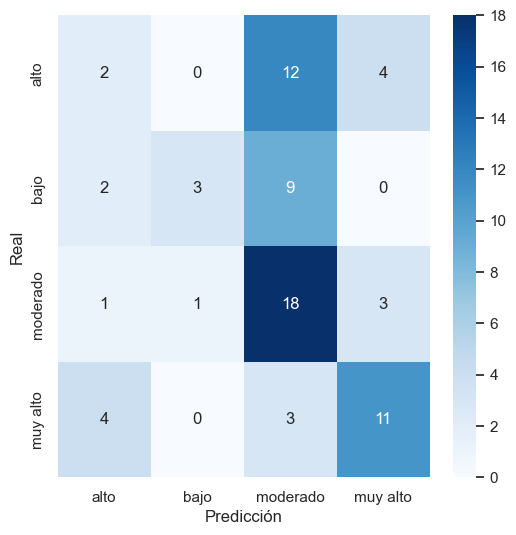

In [107]:
# Creamos una matriz de confusión
# ==============================================================================

matriz_confusion = confusion_matrix(y_test, predicciones_modelo_SVC)

fig, axes = plt.subplots(figsize=(6, 6))

sns.heatmap(ax= axes, data=matriz_confusion, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels= modelo_SVC.classes_, 
            yticklabels= modelo_SVC.classes_
            )

axes.set_xlabel('Predicción')
axes.set_ylabel('Real');

De acuerdo con la matriz de confusión, podemos observar lo siguiente:

- Respecto a la categoría **"muy alto"**, el modelo predijo 18 observaciones en esta categoría, pero solo 11 realmente pertenecían a ella.

- Respecto a la categoría **"moderado"**, el modelo predijo 42 observaciones en esta categoría, pero solo 18 fueron correctamente clasificadas.

- Respecto a la categoría **"bajo"**, el modelo predijo 4 observaciones, y solo una fue correctamente clasificada.

- Finalmente, para la categoría **"alto"**, el modelo predijo 9 observaciones, pero solo 2 fueron correctamente clasificadas en esta categoría.

## 4.2 Regresión Logística

A continuación, generaremos un modelo de regresión logística multinomial que nos permitirá predecir la propina según los rangos establecidos previamente. Este enfoque es adecuado cuando la variable objetivo tiene más de dos categorías, como en nuestro caso, con las categorías "bajo", "moderado", "alto" y "muy alto". 

La regresión logística multinomial asigna probabilidades a cada categoría en función de las características de los datos, permitiéndonos obtener la clase más probable para cada observación. Además, evaluaremos el rendimiento del modelo utilizando las métricas de precisión, recall y f1-score, lo que nos permitirá comparar este modelo con el rendimiento obtenido en el modelo de Máquinas de Vectores de Soporte (SVM).

In [108]:
# Generamos el modelo de Regresión Logística y entrenamos el modelo
# ==============================================================================

modelo_regresion_logistica = LogisticRegression(multi_class='multinomial', 
                                                solver='lbfgs', 
                                                random_state=0
                                                )

modelo_regresion_logistica.fit(X_train_estandarizado, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

Una vez que el modelo haya sido entrenado, procederemos a generar las predicciones sobre el conjunto de datos de prueba. Estas predicciones nos permitirán evaluar el rendimiento del modelo y determinar su capacidad para generalizar a datos no vistos, proporcionando una medida de qué tan bien el modelo puede clasificar correctamente nuevas observaciones que no formaron parte del entrenamiento.

In [109]:
# Hallamos las predicciones del modelo de Regresión Logística
# ==============================================================================

predicciones_modelo_regresion_logistica = modelo_regresion_logistica.predict(X_test_estandarizado)
predicciones_modelo_regresion_logistica

array(['muy alto', 'alto', 'muy alto', 'muy alto', 'moderado', 'moderado',
       'moderado', 'muy alto', 'moderado', 'moderado', 'muy alto', 'bajo',
       'bajo', 'bajo', 'muy alto', 'moderado', 'bajo', 'moderado',
       'moderado', 'moderado', 'alto', 'moderado', 'muy alto', 'muy alto',
       'muy alto', 'moderado', 'moderado', 'alto', 'alto', 'moderado',
       'muy alto', 'moderado', 'moderado', 'moderado', 'moderado',
       'muy alto', 'moderado', 'moderado', 'muy alto', 'moderado',
       'moderado', 'moderado', 'muy alto', 'bajo', 'moderado', 'alto',
       'moderado', 'moderado', 'alto', 'muy alto', 'moderado', 'muy alto',
       'muy alto', 'alto', 'moderado', 'muy alto', 'moderado', 'muy alto',
       'alto', 'muy alto', 'moderado', 'muy alto', 'bajo', 'muy alto',
       'alto', 'alto', 'moderado', 'bajo', 'bajo', 'moderado', 'bajo',
       'bajo', 'bajo'], dtype=object)

A continuación, procedemos a evaluar el modelo a través de sus principales métricas de bondad de ajuste. Estas métricas nos permitirán analizar el rendimiento del modelo en términos de precisión, recall, f1-score y otras medidas clave, proporcionando una visión completa sobre su capacidad para clasificar correctamente las observaciones.

In [110]:
# Calculamos las métricas de evaluación del modelo
# ==============================================================================

print(classification_report(y_test, predicciones_modelo_regresion_logistica))

              precision    recall  f1-score   support

        alto       0.30      0.17      0.21        18
        bajo       0.64      0.50      0.56        14
    moderado       0.45      0.61      0.52        23
    muy alto       0.67      0.78      0.72        18

    accuracy                           0.52        73
   macro avg       0.51      0.51      0.50        73
weighted avg       0.50      0.52      0.50        73



Ahora procederemos a interpretar las métricas del modelo de regresión logística y compararlas con las métricas obtenidas previamente en el modelo de Máquinas de Vectores de Soporte (SVM). Este análisis nos permitirá evaluar cuál de los dos modelos tiene un mejor rendimiento y cuál es más adecuado para este conjunto de datos.

- **Categoria "muy alto"**: En la categoría "muy alto", el modelo de regresión logística logró un desempeño robusto, con una precisión del 67% y un recall del 78%, lo que refleja que el modelo es efectivo tanto en identificar correctamente las instancias verdaderas como en realizar predicciones acertadas. En comparación, el modelo de SVM obtuvo una precisión y un recall más bajos, ambos del 61%. Esto sugiere que la regresión logística tiene un rendimiento claramente superior en esta categoría, con un puntaje F1 del 72%, frente al 61% de SVM, lo que demuestra una mayor capacidad de generalización para esta clase.

- **Categoría "alto"**: En la categoría "alto", la regresión logística alcanzó una precisión del 30% y un recall del 17%, lo que significa que el 30% de las predicciones realizadas para esta categoría fueron correctas y que el modelo fue capaz de identificar correctamente el 17% de las instancias reales de esta categoría. En comparación, el modelo de SVM presentó una precisión del 22% y un recall del 11% para esta misma categoría, esto muestra que la regresión logística tiene un mejor rendimiento en la clasificación de la categoría "alto", tanto en términos de precisión como de recall, aunque en ambos modelos el rendimiento en esta categoría sigue siendo bajo.

- **Categoria "moderado"**: En la categoría "moderado", el modelo de regresión logística obtuvo una precisión del 45% y un recall del 61%, lo que sugiere un rendimiento equilibrado, donde el 45% de las predicciones fueron correctas y el modelo logró capturar el 61% de las observaciones reales. El modelo de SVM tuvo un comportamiento similar, con una precisión del 43% y un recall superior del 78%. Esto indica que, en esta categoría, SVM es más efectivo para capturar instancias verdaderas, aunque su precisión al predecir las observaciones correctamente fue ligeramente inferior a la de la regresión logística. Sin embargo, el modelo SVM mostró un mejor equilibrio entre precisión y recall en esta categoría, reflejado en un puntaje F1 superior (55% en SVM frente a 52% en la regresión logística).

- **Categoria "bajo"**: En la categoría "bajo", el modelo de regresión logística logró una precisión del 64% y un recall del 50%, lo que indica un desempeño razonable. El modelo fue capaz de predecir correctamente el 64% de las observaciones y capturó el 50% de las instancias reales. El modelo de SVM mostró una mayor precisión en esta categoría, alcanzando un 75%, pero su recall fue mucho menor, del 21%, esto indica que, aunque SVM fue más preciso al clasificar correctamente las observaciones predichas, fue menos capaz de capturar la totalidad de las instancias reales de la categoría. La regresión logística, por su parte, logró un mejor balance entre precisión y recall, lo que se refleja en un puntaje F1 superior (56% en regresión logística frente a 33% en SVM).

- Respecto a la exactitud general del modelo (Accuracy), el modelo de regresión logística obtuvo una exactitud del 52%, lo que significa que clasifica correctamente el 52% de todas las observaciones en el conjunto de prueba. Por otro lado, el modelo de SVM alcanzó una exactitud del 47%. Este resultado sugiere que, en términos generales, la regresión logística tiene un mejor desempeño al clasificar las observaciones que el modelo SVM, con una diferencia de 5 puntos porcentuales en su favor.

Comparando ambos modelos, la regresión logística muestra un mejor desempeño general, tanto en términos de exactitud como en el balance entre precisión y recall en varias categorías. El modelo de SVM ofrece una precisión superior en algunas categorías, como "bajo", pero sacrifica recall, lo que puede ser problemático si se busca capturar la mayor cantidad de instancias verdaderas. Por otro lado, la regresión logística mantiene un mejor equilibrio entre ambas métricas, particularmente en las categorías de "bajo" y "muy alto", lo que la hace más adecuada para este conjunto de datos.

# Referencias Bibliográficas

- Betancourt, G. A. (2005). Las máquinas de soporte vectorial (SVMs). Scientia et technica, 1(27)

- Máquinas de Vector Soporte (SVM) con Python por Joaquín Amat Rodrigo, disponible con licencia CC BY-NC-SA 4.0 en https://www.cienciadedatos.net/documentos/py24-svm-python.html

- Morales, E., González, J., & Escalante, H. J. (2017). Maquinas de Soporte Vectorial.

- Xue, H., Yang, Q., & Chen, S. (2009). SVM: Support vector machines. In The top ten algorithms in data mining (pp. 51-74). Chapman and Hall/CRC.